# TP MAP6009
* Objectif: Prédire le risque de rotation
* Auteurs:
  * Fezeu Ghomsi Eugene Clotaire
  * Moussa
* Depot: [github.com/fez2010/tp_map6014](https://github.com/fez2010/tp_map6014)

In [49]:
!cat /etc/os-release

PRETTY_NAME="Ubuntu 22.04.3 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.3 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


In [50]:
!pip install seaborn[stats]
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install sklearn
!pip install imblearn
!pip install joblib

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, ShuffleSplit,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.decomposition import PCA
from imblearn.over_sampling import SVMSMOTE
from joblib import dump, load
from pathlib import Path
import os
import platform



In [52]:
print(platform.machine(), platform.system(),platform.node(), platform.python_version(), platform.python_compiler(), platform.architecture())

x86_64 Linux ec945a2b6298 3.10.12 GCC 11.4.0 ('64bit', 'ELF')


In [53]:
mpl.set_loglevel("debug")
if platform.system() == 'Linux':
  font_paths = mpl.font_manager.findSystemFonts()
  for font_file in font_paths:
    mpl.font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (3.1, 3)


In [54]:
sns.set_theme(style="white", rc={"grid.linewidth": 0.1, 'figure.figsize':(3.1,3)})
sns.set_style("ticks")
sns.set(font='Arial')
sns.set_context("paper", font_scale=0.9)
#plt.figure(figsize=(3.1, 3))
#sns.despine(left=False, bottom=False)

In [55]:

def in_ggole_colab():
  return os.getenv("COLAB_RELEASE_TAG") != None
def set_title(fig, title):
  if(in_ggole_colab()):
    fig.set_title(title)
def title(fig, title):
  if(in_ggole_colab()):
    fig.title(title)
def save_figure(fig,name):
  prefix = './outputs/images/'
  svg_prefix = f'{prefix}svg/'
  png_prefix = f'{prefix}png/'
  eps_prefix = f'{prefix}eps/'
  pdf_prefix = f'{prefix}pdf/'
  prefixs = [svg_prefix, png_prefix, eps_prefix, pdf_prefix]
  prefixs_names = ['svg', 'png', 'eps', 'pdf']
  for p in prefixs:
    Path(p).mkdir(parents=True, exist_ok=True)
  for i in range(len(prefixs)):
    fig.savefig(f'{prefixs[i]}{name}.{prefixs_names[i]}', format=prefixs_names[i], bbox_inches='tight', dpi=96)


## Lecture des données depuis le dépot distant

In [56]:
FILES_PATHS = ['https://raw.githubusercontent.com/fez2010/tp_map6014/refs/heads/main/datasets/turnover.csv','https://raw.githubusercontent.com/fez2010/tp_map6014/refs/heads/main/datasets/turnover_prepared.csv']
datasets = []
for path in FILES_PATHS:
  #get csv file encoding
  df = pd.read_csv(path, encoding='Latin-1')

  df.columns = df.columns.str.capitalize()
  datasets.append(df)

print(datasets[1].shape)
datasets[0].head()

(1129, 17)


,Stag,Event,Gender,Age,Industry,Profession,Traffic,Coach,Head_gender,Greywage,Way,Extraversion,Independ,Selfcontrol,Anxiety,Novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7


In [57]:

# Création des ensembles de nom
CATEGORY_COLUMNS= ['Industry', 'Profession','Traffic', 'Coach', 'Head_gender','Greywage','Way','Gender']
QUANTITATIVE_COLUMNS = ['Age','Stag','Novator','Anxiety','Selfcontrol','Independ','Extraversion','Wayencoded']
REAL_QUANTITATIVE_COLUMNS = ['Stag', 'Novator','Anxiety','Selfcontrol','Independ','Extraversion']
INTEGER_QUANTITATIVE_COLUMNS = ['Age', 'Wayencoded']
# Liste des variables explicatives
EXPLICATIVES_COLUMNS = CATEGORY_COLUMNS + QUANTITATIVE_COLUMNS
# Classe Cible
TARGET = 'Event'
# Codes Couleur
COLOR_PALETTE = ['#8B383F','#373D61','#203AE0']

# Recherche des valeurs manquantes

In [58]:
print(datasets[0].isnull().sum())


Stag            0
Event           0
Gender          0
Age             0
Industry        0
Profession      0
Traffic         0
Coach           0
Head_gender     0
Greywage        0
Way             0
Extraversion    0
Independ        0
Selfcontrol     0
Anxiety         0
Novator         0
dtype: int64


In [59]:
print(datasets[1].isnull().sum())

Stag            0
Event           0
Gender          0
Age             0
Industry        0
Profession      0
Traffic         0
Coach           0
Head_gender     0
Greywage        0
Way             0
Extraversion    0
Independ        0
Selfcontrol     0
Anxiety         0
Novator         0
Wayencoded      0
dtype: int64


# Liste de valeurs des variables catégoriels


In [60]:
for column in CATEGORY_COLUMNS:
  print(f'Les valeurs de la colonne {column} sont : ',', '.join(datasets[0][column].unique()))


Les valeurs de la colonne Industry sont :  Banks, PowerGeneration, Retail, manufacture, Consult, State, etc, Building, IT,  HoReCa, Telecom, Pharma, Mining, transport, Agriculture, RealEstate
Les valeurs de la colonne Profession sont :  HR, Commercial, Marketing, etc, Sales, BusinessDevelopment, Finanñe, Teaching, manage, IT, Law, Consult, Engineer, PR, Accounting
Les valeurs de la colonne Traffic sont :  rabrecNErab, empjs, youjs, referal, advert, KA, recNErab, friends
Les valeurs de la colonne Coach sont :  no, yes, my head
Les valeurs de la colonne Head_gender sont :  f, m
Les valeurs de la colonne Greywage sont :  white, grey
Les valeurs de la colonne Way sont :  bus, car, foot
Les valeurs de la colonne Gender sont :  m, f


In [61]:
def get_description(dataset):
  description = dataset.describe(include='all')
  description = dataset.describe(include='all')
  description.loc['var'] = dataset.var().tolist()
  description.loc['skew'] = dataset.skew().tolist()
  description.loc['kurt'] = dataset.kurtosis().tolist()
  return description
print(get_description(datasets[1]))
#stats.normaltest(datasets[1][TARGET])
Path("./outputs/csv/").mkdir(parents=True, exist_ok=True)
get_description(datasets[1]).to_csv('./outputs/csv/stats.csv')


              Stag        Event       Gender          Age     Industry  \
count  1129.000000  1129.000000  1129.000000  1129.000000  1129.000000   
mean     36.627526     0.505757     0.244464    31.066965     8.614703   
std      34.096597     0.500188     0.429959     6.996147     4.232955   
min       0.394251     0.000000     0.000000    18.000000     0.000000   
25%      11.728953     0.000000     0.000000    26.000000     5.000000   
50%      24.344969     1.000000     0.000000    30.000000    10.000000   
75%      51.318275     1.000000     0.000000    36.000000    12.000000   
max     179.449692     1.000000     1.000000    58.000000    15.000000   
var    1162.577925     0.250188     0.184865    48.946076    17.917904   
skew      1.489674    -0.023061     1.190760     0.660865    -0.282009   
kurt      2.040805    -2.003020    -0.583126     0.069048    -1.194902   

        Profession      Traffic        Coach  Head_gender     Greywage  \
count  1129.000000  1129.000000  1129

In [62]:
data = datasets[1][TARGET].value_counts()

In [63]:
data.values


array([571, 558])

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.640000000000002.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.640000000000002.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSiz

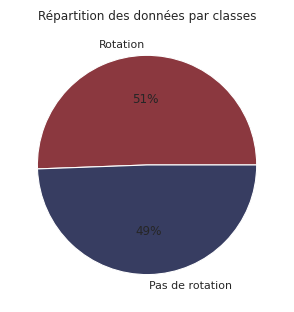

In [64]:
# Graphe de la repartion des données par classe
with sns.axes_style("ticks"):
  splot = plt.pie(data, labels=['Rotation', 'Pas de rotation'], colors=COLOR_PALETTE, autopct='%.0f%%')
  plt.xticks(rotation=90)
  plt.tight_layout()

  save_figure(plt, 'dataset_pie_chart')
  title(plt,'Répartition des données par classes')
  plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

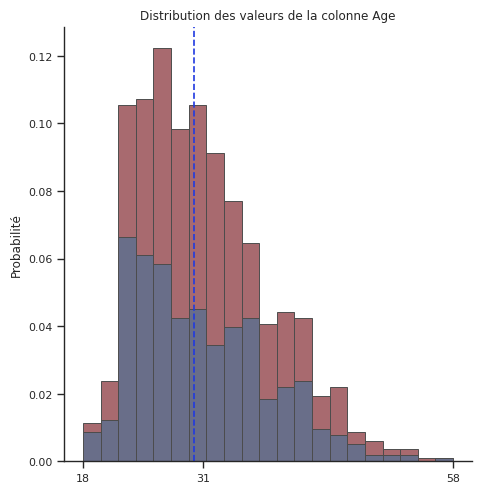

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

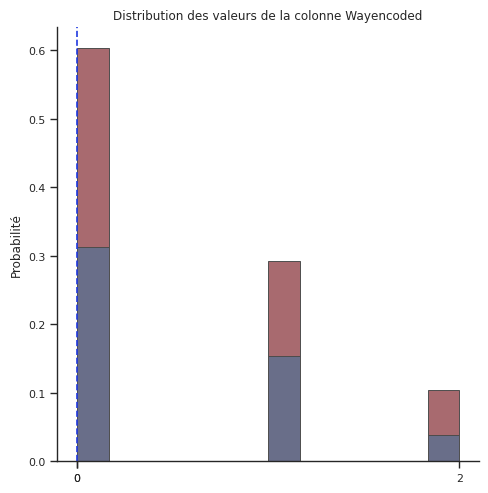

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

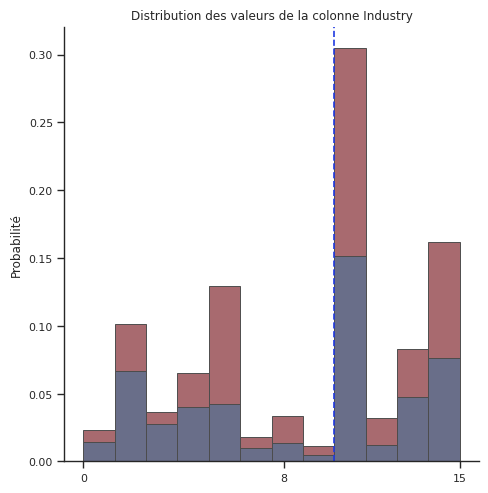

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

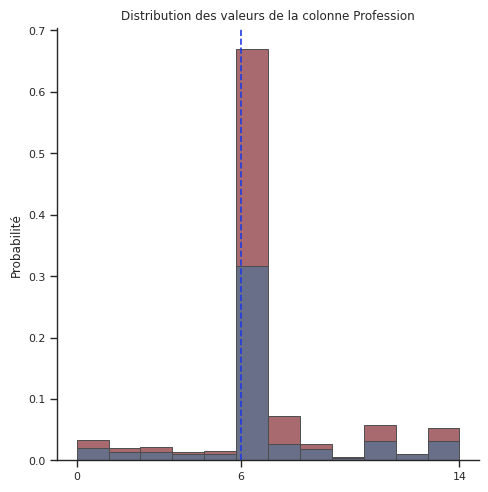

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

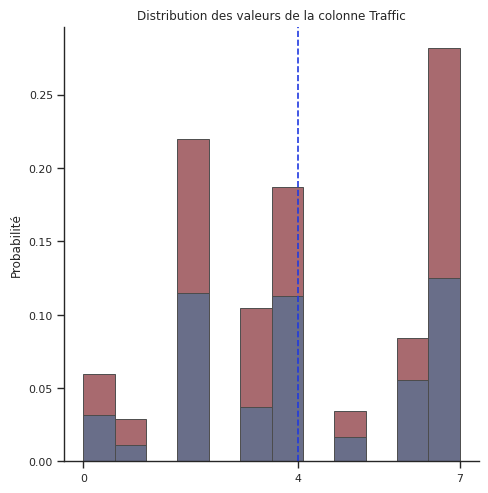

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

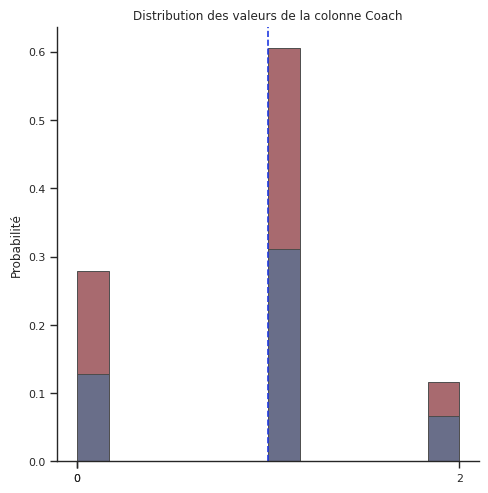

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

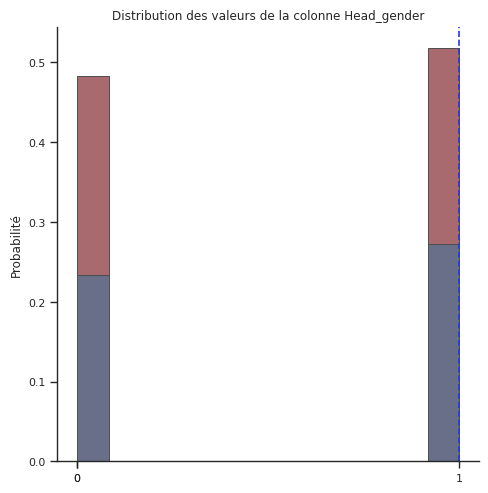

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

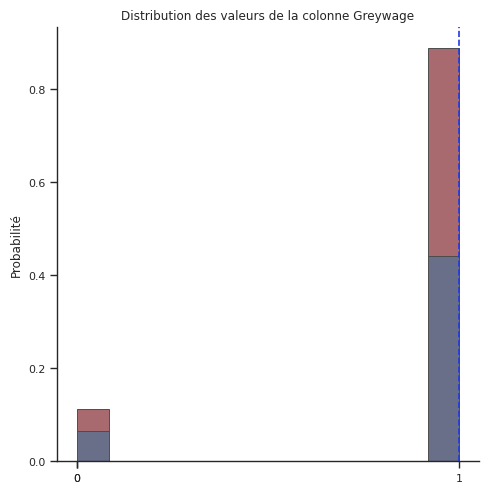

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

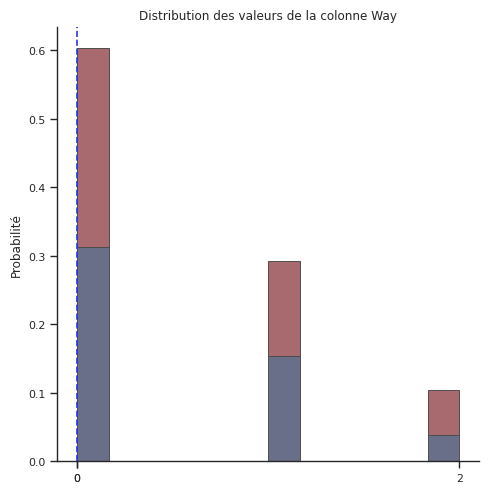

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

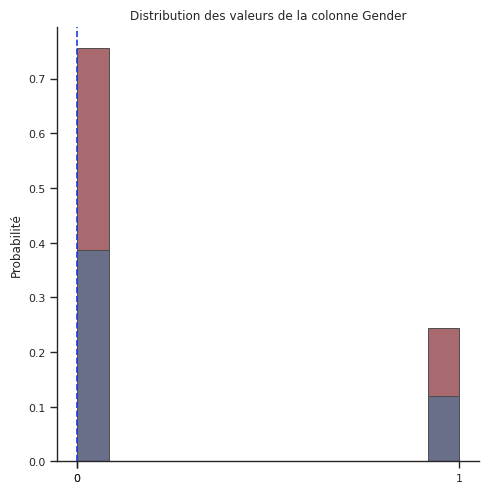

In [65]:
with sns.axes_style("ticks"):
  for column in INTEGER_QUANTITATIVE_COLUMNS + CATEGORY_COLUMNS:
    splot = sns.displot(
        datasets[1],
        x=column, hue=TARGET,
        multiple="stack",
        palette=COLOR_PALETTE[0:2],
        edgecolor=".3",
        linewidth=.7,
        stat="probability",
        log_scale=False,
    )

    x_ticks = [int(x) for x in datasets[1][column].unique()]
    splot.ax.set_xticks( [min(x_ticks), int(datasets[1][column].mean()) ,max(x_ticks)])
    plt.axvline(datasets[1][column].median(), color=COLOR_PALETTE[2],linestyle='--', label='Médiane')
    splot.legend.remove()
    splot.ax.set_ylabel("Probabilité")
    splot.ax.set_xlabel("")
    #splot.ax.set_title(f"Distribution des valeurs de la colonne {column}")
    save_figure(splot, f'distribution_{column}')
    set_title(splot.ax,f'Distribution des valeurs de la colonne {column}')
    plt.show()


<ipython-input-66-6fe55fda07e3>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


<Figure size 310x300 with 0 Axes>

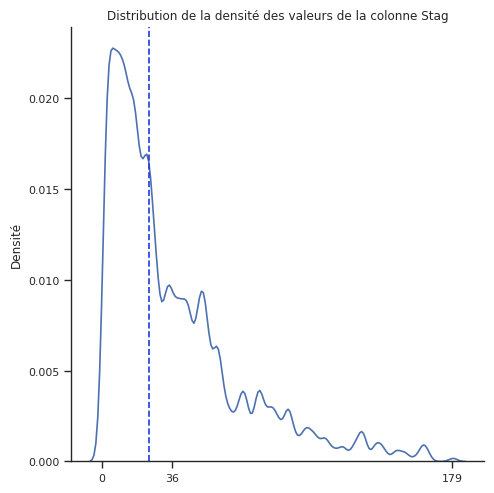

<ipython-input-66-6fe55fda07e3>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


<Figure size 310x300 with 0 Axes>

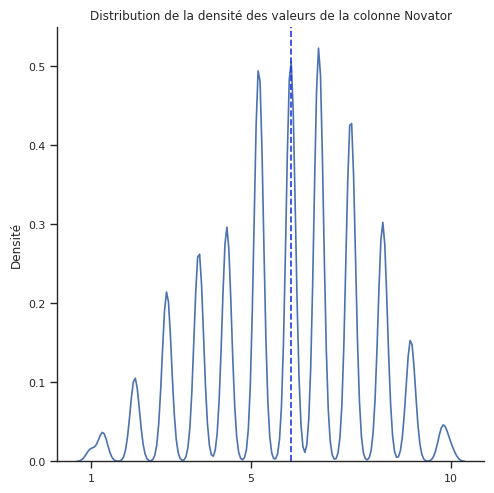

<ipython-input-66-6fe55fda07e3>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


<Figure size 310x300 with 0 Axes>

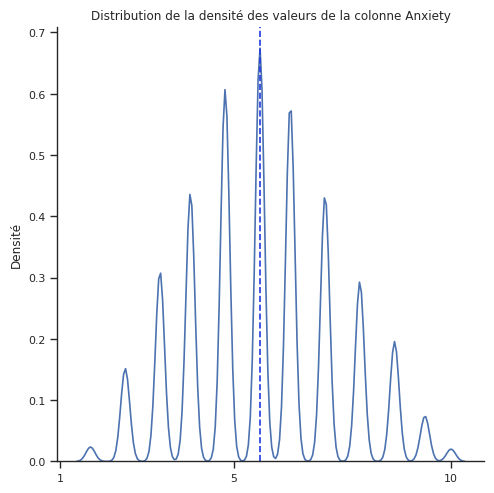

<ipython-input-66-6fe55fda07e3>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


<Figure size 310x300 with 0 Axes>

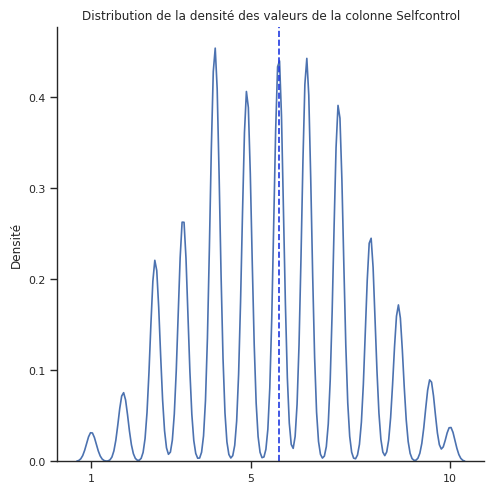

<ipython-input-66-6fe55fda07e3>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


<Figure size 310x300 with 0 Axes>

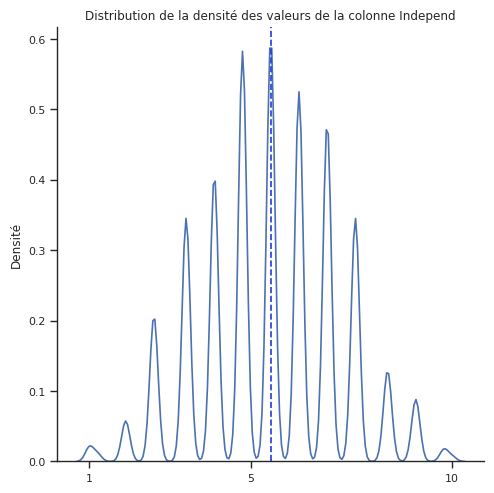

<ipython-input-66-6fe55fda07e3>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


<Figure size 310x300 with 0 Axes>

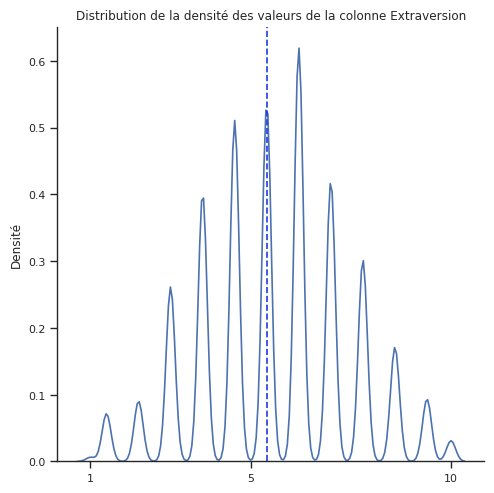

In [66]:
with sns.axes_style("ticks"):
  for column in REAL_QUANTITATIVE_COLUMNS:
    plt.figure(figsize=(3.1, 3))
    splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)

    plt.legend().remove()
    x_ticks = [int(x) for x in datasets[1][column].unique()]
    splot.ax.set_xticks( [min(x_ticks), int(datasets[1][column].mean()) ,max(x_ticks)])
    plt.axvline(datasets[1][column].median(), color=COLOR_PALETTE[2],linestyle='--', label='Médiane')
    splot.ax.set_ylabel("Densité")
    splot.ax.set_xlabel("")
    #splot.ax.set_title(f"Distribution de la densité des valeurs de la colonne {column}")
    save_figure(splot, f'density_distribution_{column}')
    set_title(splot.ax,f'Distribution de la densité des valeurs de la colonne {column}')
    plt.show()



## Détection des outliers
Test de la meilleur des manieres de supprimer les outliers entre IQR et Z-score avec seuil manuel

### Normalisation des données

In [67]:
scaler = StandardScaler()
f_scaler = scaler
b = datasets[1].copy()
b[EXPLICATIVES_COLUMNS] = scaler.fit_transform(b[EXPLICATIVES_COLUMNS])

### Identification des colonnes qui ont des outliers

DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


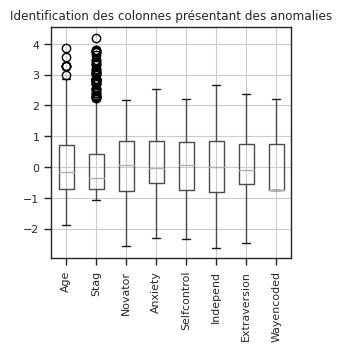

In [68]:
with sns.axes_style("ticks"):
  b[QUANTITATIVE_COLUMNS].boxplot(figsize=(3.1, 3))
  plt.xticks(rotation=90)
  save_figure(plt, f'main_boxplot_show_outlier_columns')
  title(plt,'Identification des colonnes présentant des anomalies')
  plt.show()



### Détection des outliers avec IQR

In [69]:
IQR_dataset = b.copy()

DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


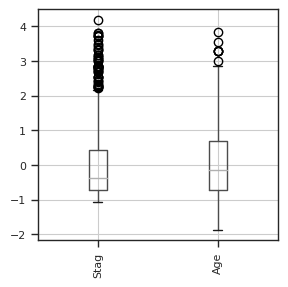

EIQ de la colonne Stag  1.1616076227225083
Limite supérieur de la colonne Stag: 2.1734591421957954
52
Limite inférieur de la colonne Stag: -2.4729713486942377
0


DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


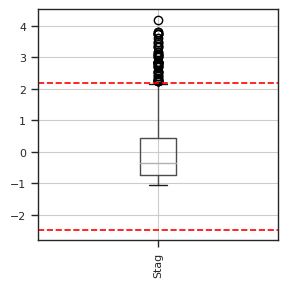

Nouvelle taille apres suppression des outliers sur la colonne Stag:  (1077, 17)
EIQ de la colonne Age  1.4299915829976453
Limite supérieur de la colonne Age: 2.8504072896600094
7
Limite inférieur de la colonne Age: -2.869559042330572
0


DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


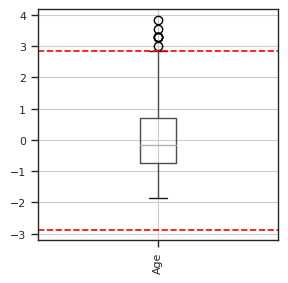

Nouvelle taille apres suppression des outliers sur la colonne Age:  (1070, 17)


DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


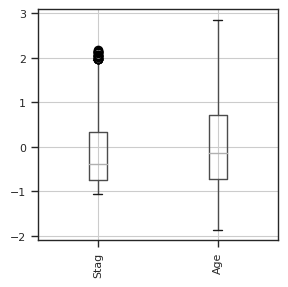

In [70]:
# Colonnes présentant des outliers
columns = ['Stag','Age']
REMOVED_COLUMNS_INDEX = []
with sns.axes_style("ticks"):
      IQR_dataset[columns].boxplot(figsize=(3.1, 3))
      plt.xticks(rotation=90)
      save_figure(plt, f'boxplot_show_outlier_column_{column}')
      plt.show()

def remove_outliers(IQR_dataset, columns):
  for column in columns:
    # EIQ
    Q1 = np.percentile(IQR_dataset[column], 25, method='midpoint')
    Q3 = np.percentile(IQR_dataset[column], 75, method='midpoint')
    IQR = Q3 - Q1
    print(f"EIQ de la colonne {column} ", IQR)

    # Limite supérieur
    upper = Q3+1.5*IQR
    upper_array = np.array(IQR_dataset[column] >= upper)
    print(f"Limite supérieur de la colonne {column}:", upper)
    print(upper_array.sum())

    # Limite inférieur
    lower = Q1-1.5*IQR
    lower_array = np.array(IQR_dataset[column] <= lower)
    print(f"Limite inférieur de la colonne {column}:", lower)
    print(lower_array.sum())


    # Création du tableau Boolean indiquant les lignes ayant des outliers
    upper_array = np.where(IQR_dataset[column] >= upper)[0]
    lower_array = np.where(IQR_dataset[column] <= lower)[0]
    with sns.axes_style("ticks"):
      IQR_dataset[[column]].boxplot(figsize=(3.1, 3))
      plt.xticks(rotation=90)
      plt.axhline(upper, color='red', linestyle='--', label="Limites")
      plt.axhline(lower, color='red', linestyle='--', )
      save_figure(plt, f'boxplot_show_outlier_column_{column}')
      plt.show()

    REMOVED_COLUMNS_INDEX = np.concatenate((upper_array, lower_array))
    REMOVED_COLUMNS_INDEX = np.unique(np.array(REMOVED_COLUMNS_INDEX.tolist(), dtype=np.int16)).tolist()
    # Suppression des outliers
    IQR_dataset.drop(index=upper_array, inplace=True)
    IQR_dataset.drop(index=lower_array, inplace=True)
    IQR_dataset.reset_index(drop=True, inplace=True)

    # Afficher la nouvelle taille du  DataFrame
    print(f"Nouvelle taille apres suppression des outliers sur la colonne {column}: ", IQR_dataset.shape)

  return IQR_dataset
IQR_dataset = remove_outliers(IQR_dataset, columns)
#IQR_dataset = remove_outliers(IQR_dataset, columns)
#IQR_dataset = remove_outliers(IQR_dataset, columns)
with sns.axes_style("ticks"):
      IQR_dataset[columns].boxplot(figsize=(3.1, 3))
      plt.xticks(rotation=90)
      save_figure(plt, f'boxplot_show_outlier_removed_on_columns')
      plt.show()


DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


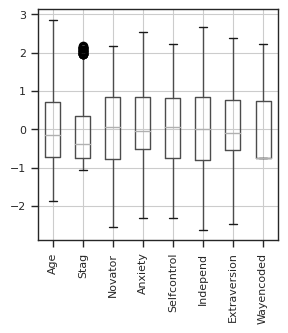

In [71]:
with sns.axes_style("ticks"):
  IQR_dataset[QUANTITATIVE_COLUMNS].boxplot(figsize=(3.1, 3))
  plt.xticks(rotation=90)
  #plt.tight_layout()
  save_figure(plt, f'main_boxplot_show_outlier_removed_on_columns')
  plt.show()


In [72]:
IQR_dataset.shape

(1070, 17)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7cb5a414fdc0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7cb5a414fdc0>
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


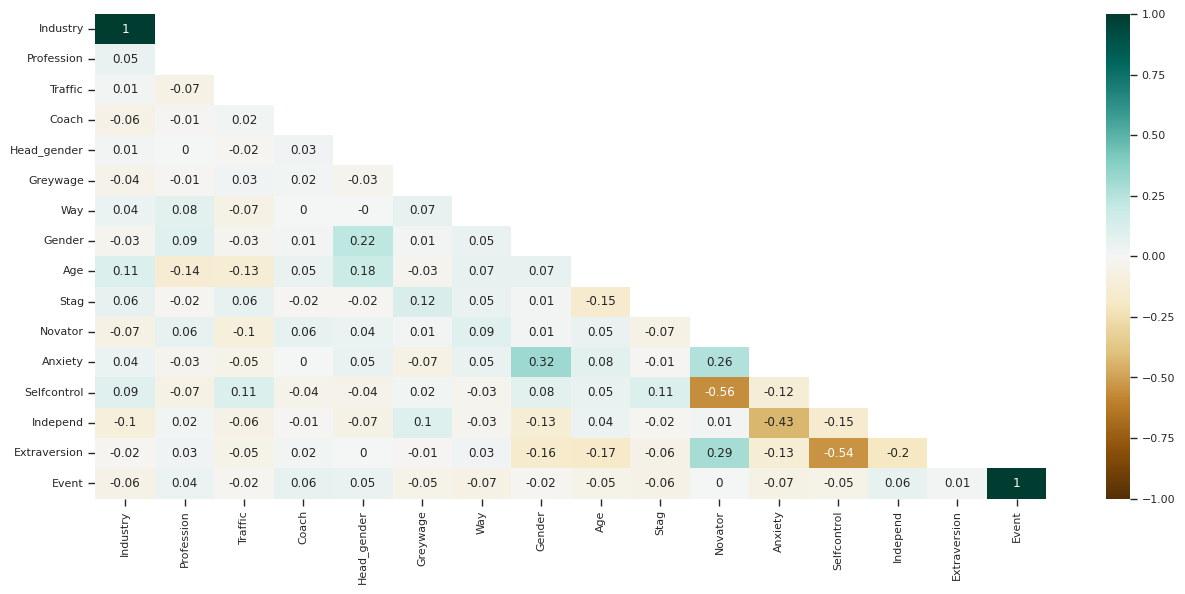

In [104]:
with sns.axes_style("ticks"):
  plt.figure(figsize=(13, 6))
  mask = np.triu(np.ones_like(IQR_dataset.corr()))
  mask[0][0] = False
  mask[mask.shape[0]-1][mask.shape[1]-1] = False
  heatmap = sns.heatmap(np.round(IQR_dataset.corr(),2), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
  plt.tight_layout()
  plt.box(False)
  save_figure(plt, 'corr_heatmap_after_removing_outlier')
  plt.show()

### Détection des outliers avec Z-score

In [74]:
ZScore_dataset = datasets[1].copy()

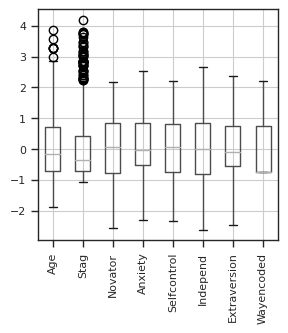

In [75]:
ZScore_dataset[EXPLICATIVES_COLUMNS] = scaler.fit_transform(ZScore_dataset[EXPLICATIVES_COLUMNS])
with sns.axes_style("ticks"):
  ZScore_dataset[QUANTITATIVE_COLUMNS].boxplot()
  plt.xticks(rotation=90)
  plt.show()

In [76]:
age_threshold_z = datasets[1]['Age'].std() * 2.8

In [77]:
outlier_indices = np.where(ZScore_dataset['Stag'] > 2.2)[0]
print(outlier_indices)
REMOVED_COLUMNS_INDEX  = np.concatenate((REMOVED_COLUMNS_INDEX, outlier_indices))
REMOVED_COLUMNS_INDEX = np.unique(np.array(REMOVED_COLUMNS_INDEX.tolist(), dtype=np.int16)).tolist()
no_outliers = ZScore_dataset.drop(outlier_indices)
print("Original DataFrame Shape:", ZScore_dataset.shape)
print("DataFrame Shape after Removing Outliers:", no_outliers.shape)

[   7  108  109  141  148  162  172  197  223  250  254  262  291  327
  328  356  366  374  379  380  394  408  409  509  515  561  568  583
  641  653  674  675  698  709  715  729  749  782  786  899  900  925
  926  960  974  983 1005 1025 1057 1082 1109 1126]
Original DataFrame Shape: (1129, 17)
DataFrame Shape after Removing Outliers: (1077, 17)


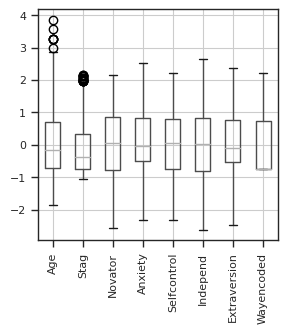

In [78]:
with sns.axes_style("ticks"):
  no_outliers[QUANTITATIVE_COLUMNS].boxplot()
  plt.xticks(rotation=90)
  plt.show()
no_outliers.reset_index(drop=True, inplace=True)

In [79]:
threshold_z = 2.8

outlier_indices = np.where(no_outliers['Age'] > threshold_z)[0]
print(outlier_indices, )
REMOVED_COLUMNS_INDEX  = np.concatenate((REMOVED_COLUMNS_INDEX, outlier_indices))
REMOVED_COLUMNS_INDEX = np.unique(np.array(REMOVED_COLUMNS_INDEX.tolist(), dtype=np.int16)).tolist()
no_outliers_2 = no_outliers.drop(outlier_indices)
print("Original DataFrame Shape:", no_outliers.shape)
print("DataFrame Shape after Removing Outliers:", no_outliers_2.shape)

[ 129  131  438  439  610  705  859  881  995 1075]
Original DataFrame Shape: (1077, 17)
DataFrame Shape after Removing Outliers: (1067, 17)


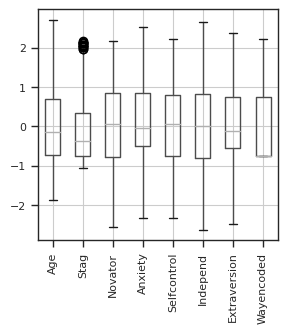

In [80]:
with sns.axes_style("ticks"):
  no_outliers_2[QUANTITATIVE_COLUMNS].boxplot()
  plt.xticks(rotation=90)
  plt.show()


In [81]:
no_outliers_2.shape

(1067, 17)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7cb5a122c4f0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7cb5a122c4f0>
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


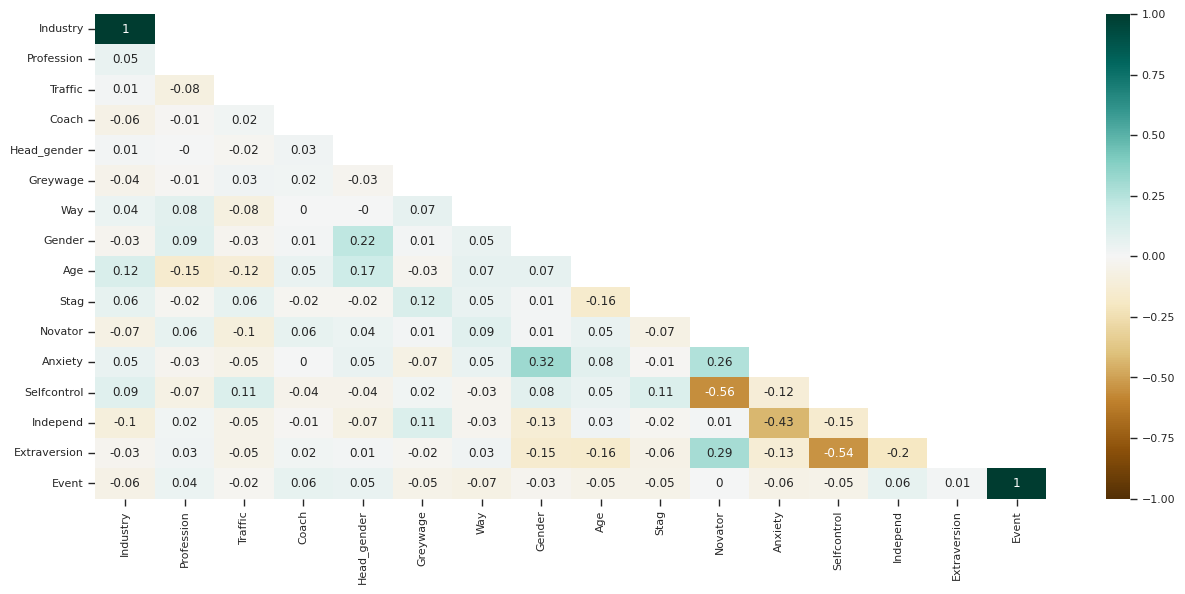

In [95]:
with sns.axes_style("ticks"):
  plt.figure(figsize=(13, 6))
  # define the mask to set the values in the upper triangle to True
  mask = np.triu(np.ones_like(no_outliers_2.corr()))
  mask[0][0] = False
  mask[mask.shape[0]-1][mask.shape[1]-1] = False
  heatmap = sns.heatmap(np.round(no_outliers_2.corr(),2), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
  heatmap.bbox_inches = 'with'
  plt.tight_layout()
  plt.box(False)
  save_figure(plt, 'corr_heatmap_after_removing_outlier_2')
  plt.show()


### Supression d'une colonne des pairs ayant les memes informations

In [83]:
REMOVED_COLUMNS = ['Wayencoded']
CATEGORY_COLUMNS= ['Industry', 'Profession','Traffic', 'Coach', 'Head_gender','Greywage','Way','Gender']
QUANTITATIVE_COLUMNS = ['Age','Stag','Novator','Anxiety','Selfcontrol','Independ','Extraversion']
EXPLICATIVES_COLUMNS = CATEGORY_COLUMNS + QUANTITATIVE_COLUMNS
IQR_dataset = IQR_dataset[EXPLICATIVES_COLUMNS + [TARGET]]
no_outliers_2 = no_outliers_2[EXPLICATIVES_COLUMNS + [TARGET]]

print(IQR_dataset.shape)
print(no_outliers_2.shape)
IQR_dataset.head()
assert IQR_dataset.shape[1] == no_outliers_2.shape[1] == datasets[1].shape[1] - len(REMOVED_COLUMNS)

(1070, 16)
(1067, 16)


In [84]:
# IQR_dataset ou ...
ACP_dataset = datasets[1].copy()
ACP_dataset.drop(index=REMOVED_COLUMNS_INDEX, inplace=True)
ACP_dataset.reset_index(drop=True, inplace=True)
ACP_dataset.shape

(1067, 17)

In [85]:
scaler = StandardScaler()
f_scaler = scaler
ACP_dataset[EXPLICATIVES_COLUMNS] = scaler.fit_transform(ACP_dataset[EXPLICATIVES_COLUMNS])

1.0000000000000004
[[ 0.12481772 -0.14151523  0.22914673 -0.08041628 -0.06738426  0.06021553
  -0.1128748   0.052987    0.06145554  0.19908424 -0.77320074 -0.22204093
   0.86948459  0.0694922  -0.70020368]
 [ 0.19237069 -0.00159826 -0.10340394  0.01821919  0.38589219 -0.17538248
   0.14034135  0.63912596  0.34028121 -0.04037627  0.1112395   0.75875464
   0.14839977 -0.55632354 -0.24378876]
 [-0.1211894  -0.11744155 -0.36209033  0.1639975   0.31470497  0.06782514
   0.10095049  0.05288776  0.67148103 -0.37555656  0.0915124  -0.21201751
  -0.07415565  0.58749682 -0.28736486]
 [ 0.00497506  0.4641984  -0.15439072 -0.04474427  0.00305127  0.55861645
   0.53674219  0.28528333 -0.1609472   0.44079574  0.0822148  -0.02521171
  -0.00451796  0.2159489  -0.11127386]
 [ 0.61692432  0.30145063 -0.3776187  -0.413173   -0.19169109 -0.3004747
   0.27728516 -0.26674373  0.14748648 -0.1635726  -0.10351273 -0.0905048
   0.05411221 -0.06430497  0.07089694]
 [-0.38119215  0.56683091 -0.17357043 -0.1772703

DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib

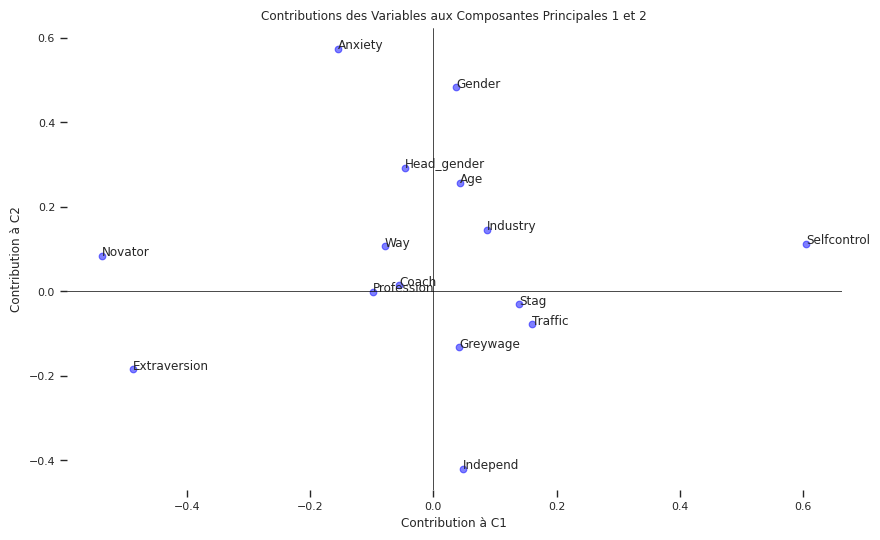

DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


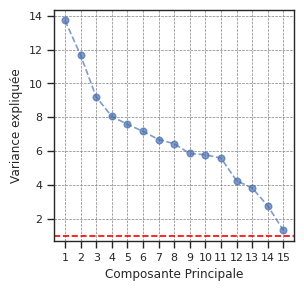

DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


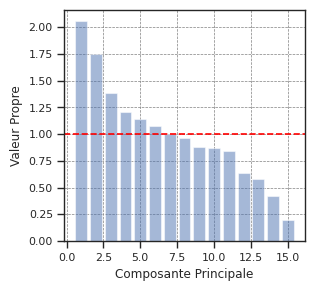

DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


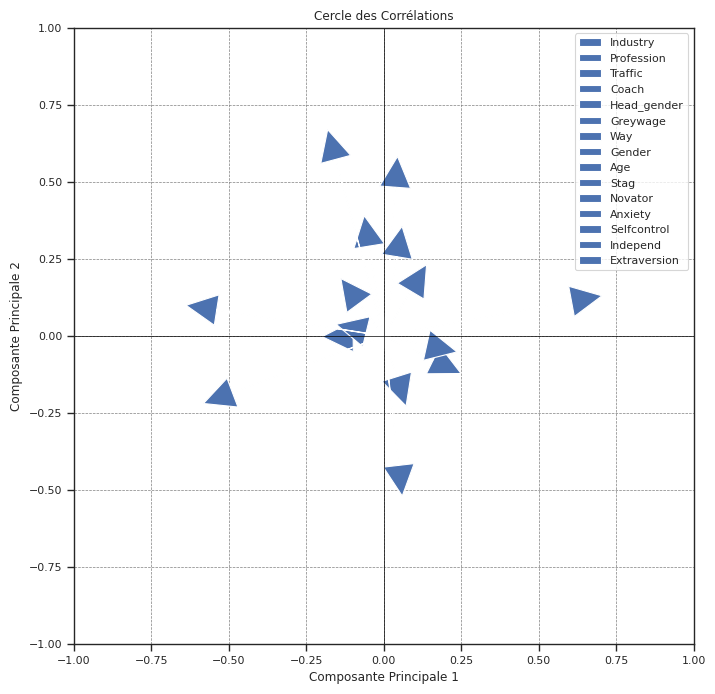

              |d(Vi-C1)|  |d(Vi-C2)|
Head_gender        0.578       0.282
Stag               0.413       0.170
Greywage           0.367       0.546
Anxiety            0.336       0.406
Way                0.327       0.344
Age                0.218       0.029
Selfcontrol        0.166       0.179
Novator            0.146       0.078
Profession         0.145       0.001
Traffic            0.103       0.100
Industry           0.087       0.099
Gender             0.061       0.255
Independ           0.030       0.077
Extraversion       0.017       0.048
Coach              0.005       0.422


,TVE,PVTE,PCVTE
C1,2.06,13.72,13.72
C2,1.75,11.67,25.39
C3,1.38,9.20,34.59
C4,1.21,8.06,42.65
C5,1.14,7.59,50.24
C6,1.08,7.18,57.41
C7,1.00,6.69,64.11
C8,0.97,6.44,70.55
C9,0.88,5.87,76.42
C10,0.87,5.80,82.21


In [103]:
def generate_components_short_names(n):
  return [f'C{i+1}' for i in range(n)]

print(np.linalg.det(ACP_dataset[EXPLICATIVES_COLUMNS].corr().to_numpy()) *
      np.linalg.det(np.transpose(np.linalg.inv(ACP_dataset[EXPLICATIVES_COLUMNS].corr().to_numpy()))))
# Créer un objet PCA
pca = PCA(random_state=0)

# Appliquer l'ACP aux données standardisées
pca.fit(ACP_dataset[EXPLICATIVES_COLUMNS])

# Composantes principales
components = pca.components_

# Variance expliquée
explained_variance = pca.explained_variance_ratio_

# Matrice des valeurs propres (Importance des facteurs)
eigenvalues = pca.explained_variance_

# Vecteurs propres (Construction des facteurs)
eigenvectors = pca.components_

# Contributions des variables aux composantes principales 1 et 2
contributions = pca.components_[:2, :].T

# Noms des variables
variable_names = ACP_dataset[EXPLICATIVES_COLUMNS].columns

# Matrice des valeurs propres
# Saturations (Importance des variables / facteurs)
loadings = eigenvectors * np.sqrt(eigenvalues.reshape(-1, 1))
print(loadings)
with sns.axes_style("ticks"):
  # Créez un graphique de dispersion des contributions
  plt.figure(figsize=(10, 6))
  plt.scatter(contributions[:, 0], contributions[:, 1], marker='o', color='blue', alpha=0.5)
  plt.xlabel('Contribution à C1')
  plt.ylabel('Contribution à C2')
  save_figure(plt, f'dispertion_of_variable_contribution_to_composent_one_and_two')

  # Ajoutez les noms des variables
  for i, variable in enumerate(variable_names):
      plt.annotate(variable, (contributions[i, 0], contributions[i, 1]))

  plt.title('Contributions des Variables aux Composantes Principales 1 et 2')
  plt.grid(color='white', linestyle='--', linewidth=0.5)
  plt.box(False)
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(0, color='black', linewidth=0.5)
  save_figure(plt, f'variable_contribution_to_composent_one_and_two')
  plt.show()

  # Visualisation des valeurs propres par pourcentage expliquer
  plt.figure(figsize=(3.1, 3))
  plt.plot(range(1, len(eigenvalues) + 1), explained_variance *100, alpha=0.7, marker='o', color='b', linestyle='--')
  plt.xticks(np.arange(1, len(eigenvalues) + 1))
  plt.xlabel('Composante Principale')
  plt.axhline(1, color='red', linestyle='--', label="Seuil de signifiance")
  plt.xlabel('Composante Principale')
  plt.ylabel('Variance expliquée')
  plt.grid(color='gray', linestyle='--', linewidth=0.5)

  save_figure(plt, f'bar_show_prinpal_components')
  plt.show()
  # Visualisation des valeurs propres
  plt.figure(figsize=(3.1, 3))
  plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.5, align='center')
  plt.axhline(1, color='red', linestyle='--', label="Seuil d'importance")
  plt.xlabel('Composante Principale')
  plt.ylabel('Valeur Propre')
  plt.grid(color='gray', linestyle='--', linewidth=0.5)

  save_figure(plt, f'bar_show_principal_component_column_s')
  plt.show()
  # Affichage du cercle des corrélations
  plt.figure(figsize=(8, 8))
  plt.title("Cercle des Corrélations")

  for i, var in enumerate(variable_names):
      x = components[0, i]
      y = components[1, i]
      plt.arrow(0, 0, x, y, head_width=0.1, head_length=0.1, label=var)
  # Ajoutez les noms des variables
  #for i, variable in enumerate(variable_names):
     # plt.annotate(variable, (contributions[i, 0], contributions[i, 1]))

  plt.xlim(-1, 1)
  plt.ylim(-1, 1)
  plt.xlabel("Composante Principale 1")
  plt.ylabel("Composante Principale 2")
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(0, color='black', linewidth=0.5)
  plt.grid(color='gray', linestyle='--', linewidth=0.5)
  plt.legend(loc='upper right')
  save_figure(plt, f'circle_of_correlation')
  plt.show()

imp = pd.DataFrame(data = { '|d(Vi-C1)|': np.round(np.absolute(components[:,0]),3), '|d(Vi-C2)|': np.round(np.absolute(components[:,1]),3) },  index=variable_names).sort_values(by=['|d(Vi-C1)|'], ascending=False)
imp.to_csv('./outputs/csv/dist_component1and2_imp.csv')
print( imp)
imp = pd.DataFrame(data = { 'TVE': np.round(eigenvalues,2), 'PVTE': np.round(explained_variance*100,2), 'PCVTE': np.round(np.cumsum(explained_variance*100),2) },  index=generate_components_short_names(len(eigenvalues)))
imp.to_csv('./outputs/csv/acp_imp.csv')
imp



In [87]:

# Nombre de composantes choisie
n = 7
pca = PCA(n_components=n, random_state=0)
sm = SVMSMOTE(random_state=0)

# Appliquer l'ACP aux données standardisées

reduced_ACP_dataset = pca.fit_transform(ACP_dataset[EXPLICATIVES_COLUMNS])
reduced_ACP_dataset = pd.DataFrame(data=reduced_ACP_dataset, columns=generate_components_short_names(n))
reduced_ACP_dataset[TARGET] = ACP_dataset[TARGET]

# Composantes principales
components = pca.components_

# Corretion du déséquilibre
X, y = sm.fit_resample(reduced_ACP_dataset[generate_components_short_names(n)], reduced_ACP_dataset[TARGET])
print(X.shape)
# Diviser le dataset en ensembles d'entraînement et de test
cv = ShuffleSplit(n_splits=500, test_size=0.3, random_state=0)

# Créer un modèle de régression logistique avec régularisation L2 (Ridge)
alpha = 1  # Paramètre de régularisation, ajustez selon vos besoins
model = LogisticRegression( penalty='l2', solver='newton-cg', random_state=0, C=1/alpha, max_iter=1000)

scoring = ['precision_micro', 'roc_auc','recall','accuracy','f1_micro']
# Entraîner le modèle sur les données d'entraînement
scores = cross_validate(model, X, y, cv=cv, scoring=scoring,return_train_score=True, return_estimator=True,  return_indices=True)
print(scores.keys(),"%0.2f accuracy with a standard deviation of %0.2f" % (scores['test_accuracy'].mean(), scores['test_roc_auc'].std()))

# Sélection du meilleur estimateur (test_recall, test_f1_micro, test_precision_micro, test_accuracy, test_roc_auc)
index = [np.where(scores['test_recall']==scores['test_recall'].max())[0],np.where(scores['test_f1_micro']==scores['test_f1_micro'].max())[0],np.where(scores['test_precision_micro']==scores['test_precision_micro'].max())[0], np.where(scores['test_accuracy']==scores['test_accuracy'].max())[0],np.where(scores['test_roc_auc']==scores['test_roc_auc'].max())[0]]
print(index)









(1080, 7)
dict_keys(['fit_time', 'score_time', 'estimator', 'indices', 'test_precision_micro', 'train_precision_micro', 'test_roc_auc', 'train_roc_auc', 'test_recall', 'train_recall', 'test_accuracy', 'train_accuracy', 'test_f1_micro', 'train_f1_micro']) 0.55 accuracy with a standard deviation of 0.03
[array([381]), array([303]), array([303]), array([303]), array([303])]


In [88]:
Index = np.concatenate(index)
Index = np.unique(np.array(Index.tolist(), dtype=np.int16)).tolist()
def generate_estimator_short_names(n):
  return [f'E{i+1}' for i in range(n)]

estimators_names = generate_estimator_short_names(len(Index))
Metrics = ['test_recall', 'test_f1_micro', 'test_precision_micro', 'test_accuracy', 'test_roc_auc']
Performances = {'#Indices': []}
maxI = 0
metricMax = 'test_accuracy'
for i in range(len(Metrics)):
  Performances[Metrics[i]] = []
  for j in range(len(Index)):
    Performances[Metrics[i]].append(round(scores[Metrics[i]][Index[j]],2))
    Performances['#Indices'].append(Index[j])
for i in range(len(Index)):
  if Performances[metricMax][i] > Performances[metricMax][maxI]:
    maxI = i
es = pd.DataFrame(Performances,columns=Metrics, index=estimators_names)

es.columns =  es.columns.str.capitalize()
es.columns =  es.columns.str.replace('_', ' ')
es['#Indice'] = Index
es.to_csv('./outputs/csv/estimator_scores.csv')
es


,Test recall,Test f1 micro,Test precision micro,Test accuracy,Test roc auc,#Indice
E1,0.63,0.61,0.61,0.61,0.65,303
E2,0.75,0.59,0.59,0.59,0.62,381


DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


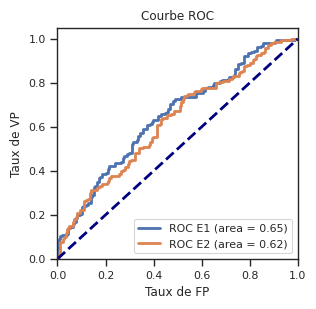

In [89]:
# Prendre l'estimateur qui a la meilleur courbe roc

def get_roc_auc(scores, index, Fclass):
  model = scores['estimator'][index]
  X_test = X.iloc[scores['indices']['test'][index]]
  y_test = y.iloc[scores['indices']['test'][index]]
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
  roc_auc = auc(fpr, tpr)
  return fpr, tpr, thresholds, roc_auc
with sns.axes_style("ticks"):
  plt.figure(figsize=(3.1, 3))
  for index in range(len(Index)):
    fpr, tpr, thresholds, roc_auc = get_roc_auc(scores, Index[index], 1)

    plt.plot(fpr, tpr,  lw=2, label=f'ROC {estimators_names[index]} (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taux de FP')
  plt.ylabel('Taux de VP')
  title(plt,'Courbe ROC')
  plt.legend(loc="lower right")
  save_figure(plt, 'roc_curve')
  plt.show()


In [90]:
model = scores['estimator'][Index[maxI]]
X_test = X.iloc[scores['indices']['test'][Index[maxI]]]
y_test = y.iloc[scores['indices']['test'][Index[maxI]]]

In [91]:
# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer les métriques de performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Afficher les métriques de performance
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.6141975308641975
Confusion Matrix:
 [[ 95  63]
 [ 62 104]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.60      0.60       158
           1       0.62      0.63      0.62       166

    accuracy                           0.61       324
   macro avg       0.61      0.61      0.61       324
weighted avg       0.61      0.61      0.61       324



DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7cb5a6aa66e0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7cb5a6aa66e0>
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


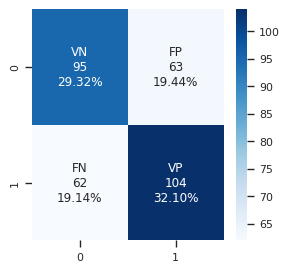

In [92]:
group_names = ['VN','FP','FN','VP']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
with sns.axes_style("ticks"):

  splot = sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
  save_figure(plt,'matrice_confusion_meilleur_estimateur')


In [93]:
# Sauvegarde des models
Path("./outputs/models/").mkdir(parents=True, exist_ok=True)
dump(model, './outputs/models/model.joblib')
dump(f_scaler, './outputs/models/scaler.joblib')
dump(pca, './outputs/models/pca.joblib')
with open('./outputs/models/model_input_columns_name.txt', 'w') as f:
  f.write(','.join(EXPLICATIVES_COLUMNS + REMOVED_COLUMNS))
with open('./outputs/models/model_pca_input_columns_name.txt', 'w') as f:
  f.write(','.join(EXPLICATIVES_COLUMNS ))

In [94]:
# Test du chargement des Models et Prediction
input_columns = []
pca_input_columns = []
with open('./outputs/models/model_input_columns_name.txt', 'r') as f:
  f.seek(0)
  input_columns = f.read().split(',')
with open('./outputs/models/model_pca_input_columns_name.txt', 'r') as f:
  f.seek(0)
  pca_input_columns = f.read().split(',')
model = load('./outputs/models/model.joblib')
scaler = load('./outputs/models/scaler.joblib')
pca = load('./outputs/models/pca.joblib')
X_test = datasets[1][input_columns].iloc[1:10]
X_test[pca_input_columns] = scaler.transform(datasets[1][pca_input_columns].iloc[1:10])
X_test_r = pca.transform(X_test[pca_input_columns])
y_pred = model.predict(X_test_r)
y_pred_proba = model.predict_proba(X_test_r)
print(y_pred, y_pred_proba)

[1 1 1 1 1 1 0 1 1] [[0.46170996 0.53829004]
 [0.43941298 0.56058702]
 [0.4245669  0.5754331 ]
 [0.4925895  0.5074105 ]
 [0.45690145 0.54309855]
 [0.45690145 0.54309855]
 [0.52490228 0.47509772]
 [0.43537852 0.56462148]
 [0.40874582 0.59125418]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
